In [78]:
from utils import *
from map_utils import *
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
import pickle
from sklearn.metrics import mean_squared_error
import numpy as np
import seaborn as sns

# 1D

In [79]:
points = get_points('../data/artificial_points.csv')
points['lat'] = points.geometry.y
points['lon'] = points.geometry.x

X = points[['lat', 'lon']].values
y = points['wait'].values

In [80]:
X

array([[      0.        , 1113194.90793274],
       [      0.        , 1424889.4821539 ],
       [      0.        , 1492794.3715378 ],
       [      0.        , 1753281.97999406],
       [      0.        , 2026014.73243758],
       [      0.        , 2449028.79745202]])

In [81]:
# TODO: set baseline that is approached when there is no data


rbf = RBF([1.0, 1.0], length_scale_bounds=(1e-05, 100000.0)) # using anisotripic kernel
kernel = ConstantKernel(constant_value=1.0, constant_value_bounds=(1e-2, 1e2)) * rbf

gp = GaussianProcessRegressor(kernel=kernel, alpha=60.0**2, n_restarts_optimizer=100, random_state=42)

In [82]:
gp.fit(X, y)


/home/till/miniconda3/envs/heatchmap/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


GaussianProcessRegressor(alpha=3600.0, kernel=1**2 * RBF(length_scale=[1, 1]),
                         n_restarts_optimizer=100, random_state=42)

In [83]:
x_test = np.linspace(start=1000000, stop=2600000, num=300)
x_test = np.array([[0, xi] for xi in x_test])

In [84]:
y_pred, sigma = gp.predict(x_test, return_std=True)

<Axes: >

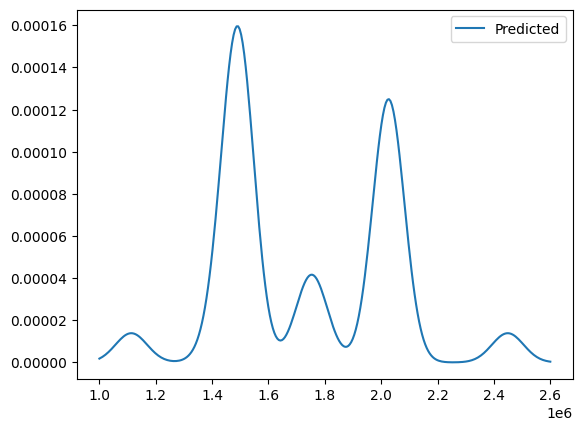

In [85]:
sns.lineplot(x=x_test[:, 1], y=y_pred, label='Predicted')

# 2D using location

In [86]:
points = get_points('../data/points_train.csv')
points['lat'] = points.geometry.y
points['lon'] = points.geometry.x

X = points[['lat', 'lon']].values
y = points['wait'].values

In [87]:
rbf = RBF([1.0, 1.0], length_scale_bounds=(1e-05, 100000.0)) # using anisotripic kernel
gp = GaussianProcessRegressor(kernel=rbf, n_restarts_optimizer=10, random_state=42)

In [88]:
gp.fit(X, y)

/home/till/miniconda3/envs/heatchmap/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


GaussianProcessRegressor(kernel=RBF(length_scale=[1, 1]),
                         n_restarts_optimizer=10)

In [89]:
with open('models/gp_model.pkl', 'wb') as f:
    pickle.dump(gp, f)
    

In [90]:
points['pred'], points['std'] = gp.predict(X, return_std=True)
mean_squared_error(points['wait'], points['pred'])

6.306088279342572e-17

In [91]:
gp = pickle.load(open('models/gp_model.pkl', 'rb'))

In [92]:
# validation
val = get_points('../data/points_val.csv')
val['lat'] = val.geometry.y
val['lon'] = val.geometry.x

X = val[['lat', 'lon']].values

In [93]:
val['pred'], val['std'] = gp.predict(X, return_std=True)
mean_squared_error(val['wait'], val['pred'])

5597.161625871128

In [94]:
val.pred.value_counts()


pred
0.000000     3284
19.395857       1
10.000000       1
Name: count, dtype: int64

In [95]:
points

,lat,lon,wait,geometry,pred,std
0,6.113303e+06,1.910272e+06,15.0,POINT (1910272.171 6113302.787),15.0,0.00001
1,6.242461e+06,1.007147e+06,2.0,POINT (1007147.218 6242460.523),2.0,0.00001
2,6.751206e+06,6.094706e+05,24.0,POINT (609470.645 6751206.171),24.0,0.00001
3,1.023051e+07,1.715154e+06,15.0,POINT (1715153.757 10230511.603),15.0,0.00001
4,9.329294e+06,1.272707e+06,15.0,POINT (1272706.784 9329294.482),15.0,0.00001
...,...,...,...,...,...,...
9880,5.997577e+06,1.670350e+06,25.0,POINT (1670350.312 5997577.376),25.0,0.00001
9881,9.010819e+06,3.268080e+06,10.0,POINT (3268079.777 9010818.827),10.0,0.00001
9882,6.625323e+06,-5.133464e+04,75.0,POINT (-51334.644 6625322.711),75.0,0.00001
9883,7.481161e+06,9.377202e+06,30.0,POINT (9377201.831 7481160.726),30.0,0.00001


## map

In [96]:
region = 'germany'
val, polygon, map_boundary = get_points_in_region(val, region)
X, Y = get_map_grid(polygon, map_boundary)
grid = np.array((Y, X)).T

In [97]:
map = np.empty((0, X.shape[0]))

for vertical_line in tqdm(grid):
    pred, stdv = gp.predict(vertical_line, return_std=True)
    map = np.vstack((map, pred))
    

100%|██████████| 100/100 [00:36<00:00,  2.75it/s]


In [98]:
map = map.T

In [99]:
np.savetxt(f'intermediate/map_gp_{region}.txt', map)

In [100]:
map.shape

(70, 100)

In [101]:
Y.shape

(70, 100)

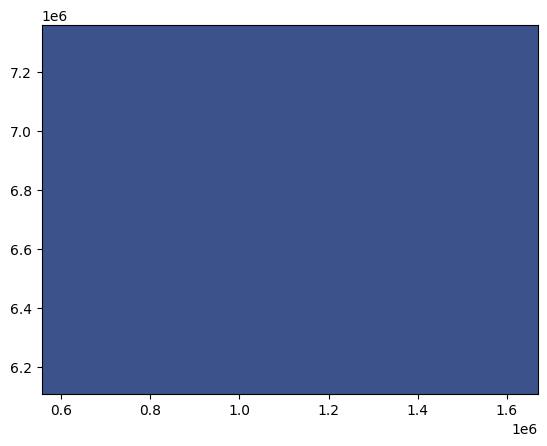

In [102]:
# preview
p = plt.contourf(X, Y, map)
plt.show()

# 3D using location and time when the spot was recorded (might use single ratings of spots here instead averaged)